In [1]:
import copy
import json
import munch
import os
import logging

from absl import app
from absl import flags
from absl import logging as absl_logging
import numpy as np
import tensorflow as tf

import equation as eqn
from solver import BSDESolver, UFModel, SharedModel, NonsharedModel, GRUModel
import matplotlib.pyplot as plt

In [2]:
exp_name = 'test'
log_dir = './logs' 

In [3]:
with open('configs/pricing_default_risk_d100.json') as json_data_file:
    config = json.load(json_data_file)

config = munch.munchify(config)

tf.keras.backend.set_floatx(config.net_config.dtype)

In [4]:
config

Munch({'eqn_config': Munch({'_comment': 'Nonlinear Black-Scholes equation with default risk in PNAS paper doi.org/10.1073/pnas.1718942115', 'eqn_name': 'PricingDefaultRisk', 'total_time': 1.0, 'dim': 100, 'num_time_interval': 40}), 'net_config': Munch({'y_init_range': [40, 50], 'num_hiddens': [110, 110], 'lr_values': [0.008, 0.008], 'lr_boundaries': [3000], 'num_iterations': 6000, 'batch_size': 64, 'valid_size': 256, 'logging_frequency': 100, 'dtype': 'float64', 'verbose': True})})

In [5]:
nsh_config = copy.deepcopy(config)

sh_config = copy.deepcopy(config)

ufm_config = copy.deepcopy(config)

rnn_config = copy.deepcopy(config)
rnn_config.net_config.num_hiddens = [110]

In [6]:
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

In [7]:
path_prefix = os.path.join(log_dir, exp_name)

with open('{}_config.json'.format(path_prefix), 'w') as outfile:
    json.dump(dict((name, getattr(config, name))
                   for name in dir(config) if not name.startswith('__')),
              outfile, indent=2)

In [8]:
absl_logging.get_absl_handler().setFormatter(logging.Formatter('%(levelname)-6s %(message)s'))
absl_logging.set_verbosity('info')
logging.info('Begin to solve %s ' % config.eqn_config.eqn_name)

In [10]:
def train_and_save(config, model, name_suffics):
    bsde = getattr(eqn, config.eqn_config.eqn_name)(config.eqn_config)
    bsde_solver = BSDESolver(config, bsde, model)
    
    training_history = bsde_solver.train()
    
    np.savetxt('%s_%s_training_history.csv' % (path_prefix, name_suffics),
               training_history,
               fmt=['%d', '%.5e', '%.5e', '%d'],
               delimiter=",",
               header='step,loss_function,target_value,elapsed_time',
               comments='')

In [11]:
for (config, model, name_suffics) in zip([nsh_config, sh_config, ufm_config, rnn_config],
                                         [NonsharedModel, SharedModel, UFModel, GRUModel],
                                         ['non_shared', 'shared', 'univ_fun', 'gru']
                                        ):
    train_and_save(config, model, name_suffics)
    print(name_suffics)

non_shared
shared
univ_fun
gru


In [12]:
import pandas as pd

In [13]:
model_names = ['non_shared', 'shared', 'univ_fun', 'gru']

dfs = [pd.read_csv('%s_%s_training_history.csv' % (path_prefix, name_suffics))
       for name_suffics in model_names
      ]

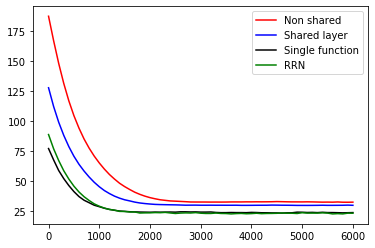

In [16]:
fig = plt.figure()

for df, c in zip(dfs, ['r', 'b', 'k', 'g']):
    _ = plt.plot(df['step'], df['loss_function'], c=c)
    
_ = plt.legend(['Non shared', 'Shared layer', 'Single function', 'RRN'])
# _ = plt.plot(df_ffn['step'], df_ffn['loss_function'], c='b')